In [212]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
import mani_skill.env
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from torch.distributions import Normal

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

#####################  hyper parameters  ####################

MAX_EPISODES = 2000               # 最大训练代数
MAX_EP_STEPS = 75               # episode最大持续帧数

CHECK_POINT_EPI = 50

RENDER = False

LOAD_MEM = False
LOAD_MODEL = False
LOAD_FOLDER_NAME = 'carbinet_OU3'

LOAD_PRETRAIN = False


ENV_NAME = 'OpenCabinetDrawer-v0'         # 游戏名称
SEED = 123                       # 随机数种子

var = 5
var_low_bound = 0.5

In [213]:
###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,hidden_dim):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.a_bound = a_bound
        self.hidden_dim = hidden_dim
        self.pointer = 0                                                                         # exp buffer指针
        self.lr_a = 0.001                                                                        # learning rate for actor
        self.lr_c = 0.001                                                                        # learning rate for critic
        self.gamma = 0.9                                                                         # reward discount
        self.tau = 0.001                                                                          # 软更新比例
        self.memory_capacity = 10000
        self.batch_size = 32
        self.memory = np.zeros((self.memory_capacity, s_dim * 2 + a_dim + 1), dtype=np.float32)

        self.Reward_record = []
        self.Success_record = np.zeros(MAX_EPISODES)
        
        class ANet(nn.Module):                               # 定义动作网络
            def __init__(self, s_dim, a_dim, a_bound,hidden_size):
                super(ANet,self).__init__()
                self.a_bound = a_bound
                
                self.linear1 = nn.Linear(s_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear4 = nn.Linear(hidden_size, a_dim)
                
                self.linear4.weight.data.uniform_(-0.03, 0.03)
                self.linear4.bias.data.uniform_(-0.03, 0.03)
#                 self.fc1 = nn.Linear(s_dim,256)
#                 self.fc1.weight.data.normal_(0,0.1)          # initialization
                
#                 self.fc2 = nn.Linear(256,512)
#                 self.fc2.weight.data.normal_(0,0.1)
#                                
#                 self.fc3 = nn.Linear(512,256)
#                 self.fc3.weight.data.normal_(0,0.1)
                
#                 self.out = nn.Linear(256,a_dim)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
            def forward(self,x):
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = F.relu(self.linear3(x))
                x = F.tanh(self.linear4(x))
                
#                 x = self.fc1(x)
#                 x = F.relu(x)
#                  
#                 x = self.fc2(x)
#                 x = F.relu(x)
                
#                 x = self.fc3(x)
#                 x = F.relu(x)
                
#                 x = self.out(x)
#                 x = F.tanh(x)
                actions_value = x * a_bound
                return actions_value

        class CNet(nn.Module):                               # 定义价值网络
            def __init__(self,s_dim,a_dim,hidden_size):
                super(CNet,self).__init__()
                
                self.linear1 = nn.Linear(s_dim + a_dim, hidden_size)
                self.linear2 = nn.Linear(hidden_size, hidden_size)
                self.linear3 = nn.Linear(hidden_size, hidden_size)
                self.linear4 = nn.Linear(hidden_size, 1)

                self.linear4.weight.data.uniform_(-0.03,0.03)
                self.linear4.bias.data.uniform_(-0.03,0.03)

#                 self.fcs1 = nn.Linear(s_dim,256)
#                 self.fcs1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs2 = nn.Linear(256,512)
#                 self.fcs2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fcs3 = nn.Linear(512,256)
#                 self.fcs3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01) 
                
#                 self.fca1 = nn.Linear(a_dim,256)
#                 self.fca1.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.fca2 = nn.Linear(256,512)
#                 self.fca2.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)              
                
#                 self.fca3 = nn.Linear(512,256)
#                 self.fca3.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
                
#                 self.out = nn.Linear(256,1)
#                 self.out.weight.data.normal_(0,0.1)          # initialization
#                 #self.fcs1.weight.data.fill_(-0.01)
            def forward(self,s,a):
        
                x = torch.cat([s, a], 1)
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = F.relu(self.linear3(x))
                x = self.linear4(x)

#                 x = self.fcs1(s)                              # 输入状态
#                 x = F.relu(x)
                
#                 x = self.fcs2(x)
#                 x = F.relu(x)
                
#                 x = self.fcs3(x)
#                 x = F.relu(x) 
                
#                 y = self.fca1(a)                              # 输入动作
#                 y = F.relu(y)
                
#                 y = self.fca2(y)                              
#                 y = F.relu(y)
                
#                 y = self.fca3(y)                              
#                 y = F.relu(y)
                
#                 net = F.relu(x+y)
#                 actions_value = self.out(net)                # 给出V(s,a)
                return x

        self.Actor_eval = ANet(s_dim, a_dim, a_bound, hidden_dim)        # 主网络
        self.Actor_target = ANet(s_dim, a_dim, a_bound, hidden_dim)      # 目标网络
        self.Critic_eval = CNet(s_dim, a_dim,hidden_dim)                # 主网络
        self.Critic_target = CNet(s_dim, a_dim,hidden_dim)              # 当前网络
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = self.lr_c) # critic的优化器
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = self.lr_a)  # actor的优化器
        self.loss_td = nn.MSELoss()                          # 损失函数采用均方误差

    def choose_action(self, s):
        s = torch.unsqueeze(torch.FloatTensor(s), 0)
        #print('choose action: ',self.Actor_eval(s))
        #print('choose action 0 : ', self.Actor_eval(s)[0])
        #print('forward: ',self.Actor_eval.forward(s))
        return self.Actor_eval(s)[0].detach()                # detach()不需要计算梯度 #用forward等价（应该

    def learn(self):

        for x in self.Actor_target.state_dict().keys():#更新target network
            eval('self.Actor_target.' + x + '.data.mul_((1 - self.tau))')  
            eval('self.Actor_target.' + x + '.data.add_(self.tau * self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1- self.tau))')
            eval('self.Critic_target.' + x + '.data.add_(self.tau * self.Critic_eval.' + x + '.data)')

        # soft target replacement

        indices = np.random.choice(self.memory_capacity, size = self.batch_size)  # 随机采样的index
        bt = self.memory[indices, :]                                              # 采样batch_size个sample
        bs = torch.FloatTensor(bt[:, :self.s_dim])                                # state
        ba = torch.FloatTensor(bt[:, self.s_dim: self.s_dim + self.a_dim])        # action
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])               # reward
        bs_ = torch.FloatTensor(bt[:, -self.s_dim:])                              # next state
        
        
        a = self.Actor_eval(bs)
        q = self.Critic_eval(bs,a)  # loss=-q=-ce(s,ae(s))更新ae   ae(s)=a   ae(s_)=a_
        # 如果 a是一个正确的行为的话，那么它的Q应该更贴近0
        loss_a = -torch.mean(q)            #一个batch输入进qu，有好多个q所以要做平均
        #print('q: ',q)
        #print('loss_a: ',loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()
        
        
        a_ = self.Actor_target(bs_)      # 这个网络不及时更新参数, 用于预测 Critic 的 Q_target 中的 action
        q_ = self.Critic_target(bs_,a_)  # 这个网络不及时更新参数, 用于给出 Actor 更新参数时的 Gradient ascent 强度
        q_target = br + self.gamma * q_  # q_target = 负的
        #print('q_target: ', q_target)
        #print('Reward: ', br)
        #print('q_: ', q_)
        q_v = self.Critic_eval(bs,ba)
        #print('q_v: ', q_v)
        td_error = self.loss_td(q_target,q_v)
        # td_error = R + self.gamma * ct（bs_,at(bs_)）-ce(s,ba) 更新ce ,但这个ae(s)是记忆中的ba，让ce得出的Q靠近Q_target,让评价更准确
        # print('td error: ', torch.mean(td_error))
        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()
        
        
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.memory_capacity     # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1                               # 指示sample位置的指针+1
    
    def store_reward(self,ep_reward):
        self.Reward_record.append(ep_reward)
        
    def Record_success(self,epi):
        self.Success_record[epi] = 1
    
    def save(self,folder_name):
        
        if os.path.exists('./DPG model/' + folder_name):
            os.rmdir('./DPG model/' + folder_name)
        
        os.mkdir('./DPG model/' + folder_name)
    
        PATH1 = './DPG model/' + folder_name + '/Actor_eval.h5f'
        PATH2 = './DPG model/' + folder_name + '/Actor_target.h5f'
        PATH3 = './DPG model/' + folder_name + '/Critic_eval.h5f'
        PATH4 = './DPG model/' + folder_name + '/Critic_target.h5f'
    
        torch.save(self.Actor_eval.state_dict(), PATH1)
        torch.save(self.Actor_target.state_dict(), PATH2)
        torch.save(self.Critic_eval.state_dict(), PATH3)
        torch.save(self.Critic_target.state_dict(), PATH4)
    
        csv_name='./DPG model/' + folder_name + '/memory.csv'
        xml_df = pd.DataFrame(self.memory)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Rewards.csv'
        xml_df = pd.DataFrame(self.Reward_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        plt.scatter(x, y)
        plt.savefig('./DPG model/' + folder_name + '/scatter.png')
        plt.plot(x, y)
        plt.savefig('./DPG model/' + folder_name + '/plot.png')
        
    def plot_file_rewards(self, folder_name):
        data = pd.read_csv('./DPG model/' + folder_name + '/Rewards.csv')
        y = np.array(data).squeeze()
        x = range(y.shape[0])
        plt.figure(figsize=(10, 10), dpi=70)
        #plt.plot(x, y)
        plt.scatter(x, y)
        plt.show()
    
    def plot_rewards(self, scatter):
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        
        if scatter:
            plt.scatter(x, y)
        else:
            plt.plot(x, y)
        plt.show()
    
    def load_model(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_target.h5f'))
        self.Actor_target.eval()
        self.Critic_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_eval.h5f'))
        self.Critic_eval.eval()
        self.Critic_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_target.h5f'))
        self.Critic_target.eval()
        print("Load network parameters of: " + LOAD_FOLDER_NAME) 
        
    def load_memory(self):
        data = pd.read_csv('./DPG model/' + LOAD_FOLDER_NAME + '/memory.csv')
        self.memory = np.array(data)
        print("Load memory of: " + LOAD_FOLDER_NAME)
        
    def load_pretrain(self):    
        ddpg.Actor_eval.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_eval.eval()
        ddpg.Actor_target.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_target.eval() 
        ddpg.Critic_eval.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
        ddpg.Critic_eval.eval()
        ddpg.Critic_target.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
        ddpg.Critic_target.eval()


In [214]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta = 0.15, max_sigma = 0.3, min_sigma = 0.3, decay_period = 100000):#decay_period要根据迭代次数合理设置
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.action_dim = action_space.shape[0]
        self.low = action_space.low
        self.high = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) *self.mu

    def evolve_state(self):
        x = self.state
        dx = self.theta* (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

Episode: 0  Reward: -560 Explore: 0.00
Episode: 1  Reward: -512 Explore: 0.00
Episode: 2  Reward: -553 Explore: 0.00
Episode: 3  Reward: -692 Explore: 0.00
Episode: 4  Reward: -564 Explore: 0.00
Episode: 5  Reward: -833 Explore: 0.00
Episode: 6  Reward: -1000 Explore: 0.00
Episode: 7  Reward: -469 Explore: 0.00
Episode: 8  Reward: -486 Explore: 0.00
Episode: 9  Reward: -541 Explore: 0.00
Episode: 10  Reward: -566 Explore: 0.00
Episode: 11  Reward: -518 Explore: 0.00
Episode: 12  Reward: -711 Explore: 0.00
Episode: 13  Reward: -306 Explore: 0.00
Episode: 14  Reward: -634 Explore: 0.00
Episode: 15  Reward: -621 Explore: 0.00
Episode: 16  Reward: -364 Explore: 0.00
Episode: 17  Reward: -605 Explore: 0.00
Episode: 18  Reward: -460 Explore: 0.00
Episode: 19  Reward: -635 Explore: 0.00
Episode: 20  Reward: -606 Explore: 0.00
Episode: 21  Reward: -842 Explore: 0.00
Episode: 22  Reward: -481 Explore: 0.00
Episode: 23  Reward: -613 Explore: 0.00
Episode: 24  Reward: -570 Explore: 0.00
Episode: 

Episode: 203  Reward: -63 Explore: 0.05
Episode: 204  Reward: -20 Explore: 0.05
Episode: 205  Reward: -95 Explore: 0.05
Episode: 206  Reward: -101 Explore: 0.06
Episode: 207  Reward: -85 Explore: 0.06
Episode: 208  Reward: -50 Explore: 0.06
Episode: 209  Reward: -54 Explore: 0.06
Episode: 210  Reward: -57 Explore: 0.06
Episode: 211  Reward: -66 Explore: 0.06
Episode: 212  Reward: -100 Explore: 0.06
Episode: 213  Reward: -182 Explore: 0.06
Episode: 214  Reward: -107 Explore: 0.06
Episode: 215  Reward: -59 Explore: 0.06
Episode: 216  Reward: -32 Explore: 0.06
Episode: 217  Reward: 2 Explore: 0.06
Episode: 218  Reward: 6 Explore: 0.06
Episode: 219  Reward: -49 Explore: 0.07
Episode: 220  Reward: -85 Explore: 0.07
Episode: 221  Reward: -78 Explore: 0.07
Episode: 222  Reward: -141 Explore: 0.07
Episode: 223  Reward: -68 Explore: 0.07
Episode: 224  Reward: -148 Explore: 0.07
Episode: 225  Reward: -11 Explore: 0.07
Episode: 226  Reward: -151 Explore: 0.07
Episode: 227  Reward: 139 Explore: 0.

Episode: 410  Reward: -29 Explore: 0.21
Episode: 411  Reward: -51 Explore: 0.21
Episode: 412  Reward: 59 Explore: 0.21
Episode: 413  Reward: 46 Explore: 0.21
Episode: 414  Reward: 55 Explore: 0.21
Episode: 415  Reward: 71 Explore: 0.21
Episode: 416  Reward: 37 Explore: 0.21
Episode: 417  Reward: -60 Explore: 0.21
Episode: 418  Reward: 28 Explore: 0.21
SUCCESS
Episode: 419  Reward: 835 Explore: 0.21
Episode: 420  Reward: -13 Explore: 0.22
Episode: 421  Reward: -164 Explore: 0.22
Episode: 422  Reward: -96 Explore: 0.22
Episode: 423  Reward: 11 Explore: 0.22
Episode: 424  Reward: -1 Explore: 0.22
Episode: 425  Reward: 34 Explore: 0.22
Episode: 426  Reward: 44 Explore: 0.22
Episode: 427  Reward: 29 Explore: 0.22
SUCCESS
Episode: 428  Reward: 545 Explore: 0.22
Episode: 429  Reward: 2 Explore: 0.22
Episode: 430  Reward: -57 Explore: 0.22
Episode: 431  Reward: 35 Explore: 0.22
Episode: 432  Reward: -22 Explore: 0.22
Episode: 433  Reward: 0 Explore: 0.23
Episode: 434  Reward: -44 Explore: 0.23

Episode: 616  Reward: -55 Explore: 0.36
Episode: 617  Reward: -38 Explore: 0.36
Episode: 618  Reward: -18 Explore: 0.36
Episode: 619  Reward: 273 Explore: 0.36
Episode: 620  Reward: -20 Explore: 0.36
Episode: 621  Reward: -28 Explore: 0.37
Episode: 622  Reward: 23 Explore: 0.37
Episode: 623  Reward: -26 Explore: 0.37
Episode: 624  Reward: -34 Explore: 0.37
Episode: 625  Reward: 6 Explore: 0.37
Episode: 626  Reward: -24 Explore: 0.37
Episode: 627  Reward: -19 Explore: 0.37
Episode: 628  Reward: 378 Explore: 0.37
Episode: 629  Reward: 507 Explore: 0.37
Episode: 630  Reward: -91 Explore: 0.37
Episode: 631  Reward: -9 Explore: 0.37
Episode: 632  Reward: -35 Explore: 0.37
Episode: 633  Reward: -134 Explore: 0.37
Episode: 634  Reward: -50 Explore: 0.38
Episode: 635  Reward: -43 Explore: 0.38
SUCCESS
Episode: 636  Reward: 500 Explore: 0.38
SUCCESS
Episode: 637  Reward: 488 Explore: 0.38
SUCCESS
Episode: 638  Reward: 751 Explore: 0.38
Episode: 639  Reward: -72 Explore: 0.38
Episode: 640  Rewar

Episode: 816  Reward: 18 Explore: 0.51
SUCCESS
Episode: 817  Reward: 750 Explore: 0.51
Episode: 818  Reward: 126 Explore: 0.51
SUCCESS
Episode: 819  Reward: 582 Explore: 0.51
Episode: 820  Reward: -130 Explore: 0.51
Episode: 821  Reward: -35 Explore: 0.51
Episode: 822  Reward: -74 Explore: 0.51
Episode: 823  Reward: -66 Explore: 0.51
Episode: 824  Reward: 136 Explore: 0.51
SUCCESS
Episode: 825  Reward: 891 Explore: 0.51
Episode: 826  Reward: -78 Explore: 0.51
Episode: 827  Reward: -191 Explore: 0.51
Episode: 828  Reward: -95 Explore: 0.51
Episode: 829  Reward: -111 Explore: 0.52
Episode: 830  Reward: -28 Explore: 0.52
SUCCESS
Episode: 831  Reward: 395 Explore: 0.52
SUCCESS
Episode: 832  Reward: 605 Explore: 0.52
SUCCESS
Episode: 833  Reward: 1036 Explore: 0.52
Episode: 834  Reward: -109 Explore: 0.52
Episode: 835  Reward: -67 Explore: 0.52
Episode: 836  Reward: -111 Explore: 0.52
Episode: 837  Reward: -83 Explore: 0.52
Episode: 838  Reward: -41 Explore: 0.52
SUCCESS
Episode: 839  Rewar

/tmp/ipykernel_3081/604114779.py:232: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10), dpi=70)


Episode: 1001  Reward: -18 Explore: 0.64
SUCCESS
Episode: 1002  Reward: 505 Explore: 0.64
Episode: 1003  Reward: -102 Explore: 0.64
Episode: 1004  Reward: -68 Explore: 0.64
Episode: 1005  Reward: -83 Explore: 0.64
Episode: 1006  Reward: -23 Explore: 0.64
Episode: 1007  Reward: -145 Explore: 0.64
Episode: 1008  Reward: 241 Explore: 0.64
Episode: 1009  Reward: -157 Explore: 0.64
Episode: 1010  Reward: -80 Explore: 0.65
SUCCESS
Episode: 1011  Reward: 860 Explore: 0.65
SUCCESS
Episode: 1012  Reward: 490 Explore: 0.65
Episode: 1013  Reward: -143 Explore: 0.65
SUCCESS
Episode: 1014  Reward: 990 Explore: 0.65
Episode: 1015  Reward: -43 Explore: 0.65
Episode: 1016  Reward: -168 Explore: 0.65
Episode: 1017  Reward: -52 Explore: 0.65
Episode: 1018  Reward: -2 Explore: 0.65
Episode: 1019  Reward: -99 Explore: 0.65
Episode: 1020  Reward: 63 Explore: 0.65
SUCCESS
Episode: 1021  Reward: 954 Explore: 0.65
Episode: 1022  Reward: 5 Explore: 0.65
SUCCESS
Episode: 1023  Reward: 815 Explore: 0.65
Episode:

SUCCESS
Episode: 1195  Reward: 440 Explore: 0.77
SUCCESS
Episode: 1196  Reward: 541 Explore: 0.78
Episode: 1197  Reward: -61 Explore: 0.78
Episode: 1198  Reward: -42 Explore: 0.78
Episode: 1199  Reward: -137 Explore: 0.78
Episode: 1200  Reward: -80 Explore: 0.78
Episode: 1201  Reward: 117 Explore: 0.78
Episode: 1202  Reward: -108 Explore: 0.78
Episode: 1203  Reward: -113 Explore: 0.78
Episode: 1204  Reward: -97 Explore: 0.78
Episode: 1205  Reward: -137 Explore: 0.78
SUCCESS
Episode: 1206  Reward: 498 Explore: 0.78
SUCCESS
Episode: 1207  Reward: 440 Explore: 0.78
Episode: 1208  Reward: -65 Explore: 0.78
Episode: 1209  Reward: -69 Explore: 0.78
SUCCESS
Episode: 1210  Reward: 668 Explore: 0.79
Episode: 1211  Reward: -125 Explore: 0.79
Episode: 1212  Reward: 50 Explore: 0.79
Episode: 1213  Reward: -74 Explore: 0.79
SUCCESS
Episode: 1214  Reward: 580 Explore: 0.79
SUCCESS
Episode: 1215  Reward: 663 Explore: 0.79
Episode: 1216  Reward: -81 Explore: 0.79
Episode: 1217  Reward: -226 Explore: 0

SUCCESS
Episode: 1385  Reward: 688 Explore: 0.90
SUCCESS
Episode: 1386  Reward: 793 Explore: 0.90
Episode: 1387  Reward: -446 Explore: 0.90
Episode: 1388  Reward: 239 Explore: 0.90
Episode: 1389  Reward: 113 Explore: 0.91
Episode: 1390  Reward: 371 Explore: 0.91
Episode: 1391  Reward: -57 Explore: 0.91
SUCCESS
Episode: 1392  Reward: 524 Explore: 0.91
Episode: 1393  Reward: 12 Explore: 0.91
Episode: 1394  Reward: -4 Explore: 0.91
SUCCESS
Episode: 1395  Reward: 738 Explore: 0.91
SUCCESS
Episode: 1396  Reward: 631 Explore: 0.91
Episode: 1397  Reward: -17 Explore: 0.91
Episode: 1398  Reward: 39 Explore: 0.91
Episode: 1399  Reward: -29 Explore: 0.91
Episode: 1400  Reward: -64 Explore: 0.91
Episode: 1401  Reward: -79 Explore: 0.91
Episode: 1402  Reward: 79 Explore: 0.91
Episode: 1403  Reward: -73 Explore: 0.92
SUCCESS
Episode: 1404  Reward: 695 Explore: 0.92
Episode: 1405  Reward: 5 Explore: 0.92
Episode: 1406  Reward: -142 Explore: 0.92
SUCCESS
Episode: 1407  Reward: 441 Explore: 0.92
SUCCE

Episode: 1575  Reward: -43 Explore: 1.00
Episode: 1576  Reward: -68 Explore: 1.00
SUCCESS
Episode: 1577  Reward: 415 Explore: 1.00
Episode: 1578  Reward: 56 Explore: 1.00
Episode: 1579  Reward: 146 Explore: 1.00
SUCCESS
Episode: 1580  Reward: 547 Explore: 1.00
Episode: 1581  Reward: 302 Explore: 1.00
SUCCESS
Episode: 1582  Reward: 601 Explore: 1.00
Episode: 1583  Reward: 61 Explore: 1.00
SUCCESS
Episode: 1584  Reward: 534 Explore: 1.00
Episode: 1585  Reward: 358 Explore: 1.00
Episode: 1586  Reward: -267 Explore: 1.00
SUCCESS
Episode: 1587  Reward: 524 Explore: 1.00
Episode: 1588  Reward: -36 Explore: 1.00
Episode: 1589  Reward: 18 Explore: 1.00
SUCCESS
Episode: 1590  Reward: 561 Explore: 1.00
Episode: 1591  Reward: -119 Explore: 1.00
SUCCESS
Episode: 1592  Reward: 661 Explore: 1.00
Episode: 1593  Reward: 91 Explore: 1.00
Episode: 1594  Reward: -50 Explore: 1.00
SUCCESS
Episode: 1595  Reward: 637 Explore: 1.00
Episode: 1596  Reward: 102 Explore: 1.00
SUCCESS
Episode: 1597  Reward: 646 E

Episode: 1763  Reward: 169 Explore: 1.00
Episode: 1764  Reward: -16 Explore: 1.00
Episode: 1765  Reward: -13 Explore: 1.00
SUCCESS
Episode: 1766  Reward: 440 Explore: 1.00
Episode: 1767  Reward: -4 Explore: 1.00
Episode: 1768  Reward: 128 Explore: 1.00
SUCCESS
Episode: 1769  Reward: 759 Explore: 1.00
SUCCESS
Episode: 1770  Reward: 633 Explore: 1.00
SUCCESS
Episode: 1771  Reward: 772 Explore: 1.00
Episode: 1772  Reward: 330 Explore: 1.00
SUCCESS
Episode: 1773  Reward: 937 Explore: 1.00
Episode: 1774  Reward: -39 Explore: 1.00
Episode: 1775  Reward: -25 Explore: 1.00
Episode: 1776  Reward: -49 Explore: 1.00
Episode: 1777  Reward: 1 Explore: 1.00
Episode: 1778  Reward: -64 Explore: 1.00
Episode: 1779  Reward: -23 Explore: 1.00
Episode: 1780  Reward: 124 Explore: 1.00
Episode: 1781  Reward: 121 Explore: 1.00
Episode: 1782  Reward: -131 Explore: 1.00
Episode: 1783  Reward: 188 Explore: 1.00
Episode: 1784  Reward: -24 Explore: 1.00
Episode: 1785  Reward: 249 Explore: 1.00
SUCCESS
Episode: 17

SUCCESS
Episode: 1951  Reward: 573 Explore: 1.00
Episode: 1952  Reward: 74 Explore: 1.00
SUCCESS
Episode: 1953  Reward: 438 Explore: 1.00
Episode: 1954  Reward: 12 Explore: 1.00
Episode: 1955  Reward: 94 Explore: 1.00
Episode: 1956  Reward: -110 Explore: 1.00
SUCCESS
Episode: 1957  Reward: 716 Explore: 1.00
Episode: 1958  Reward: -2 Explore: 1.00
Episode: 1959  Reward: -167 Explore: 1.00
Episode: 1960  Reward: 23 Explore: 1.00
Episode: 1961  Reward: 142 Explore: 1.00
SUCCESS
Episode: 1962  Reward: 525 Explore: 1.00
Episode: 1963  Reward: 2 Explore: 1.00
SUCCESS
Episode: 1964  Reward: 701 Explore: 1.00
SUCCESS
Episode: 1965  Reward: 574 Explore: 1.00
Episode: 1966  Reward: 193 Explore: 1.00
Episode: 1967  Reward: 3 Explore: 1.00
SUCCESS
Episode: 1968  Reward: 519 Explore: 1.00
Episode: 1969  Reward: -51 Explore: 1.00
SUCCESS
Episode: 1970  Reward: 728 Explore: 1.00
Episode: 1971  Reward: 23 Explore: 1.00
Episode: 1972  Reward: -142 Explore: 1.00
Episode: 1973  Reward: 63 Explore: 1.00
S

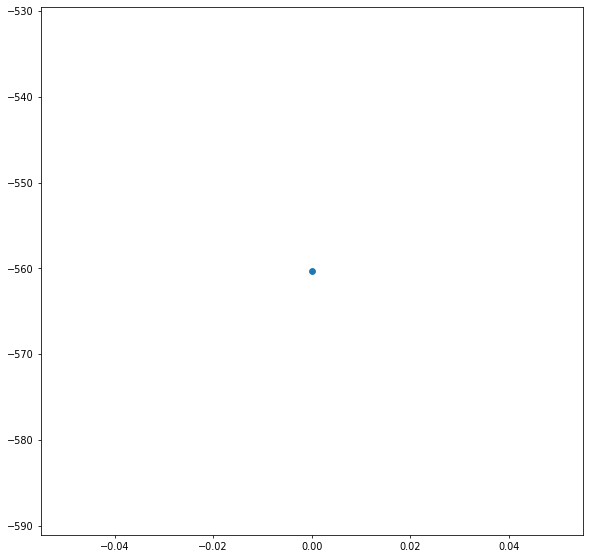

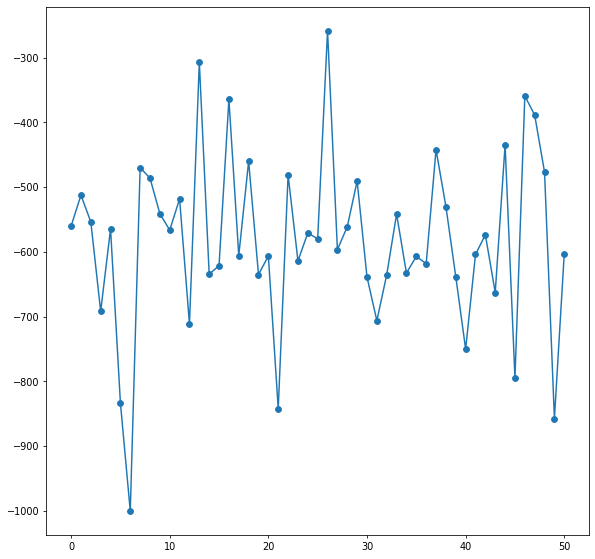

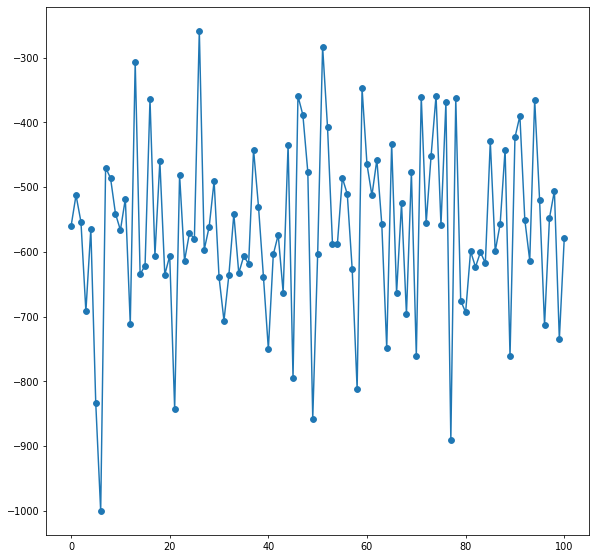

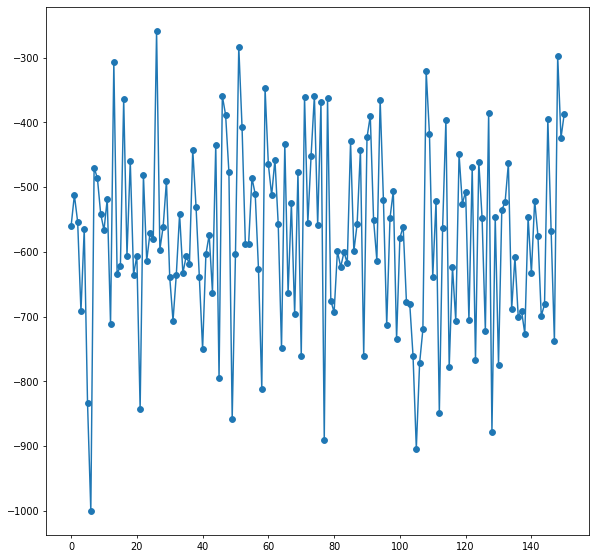

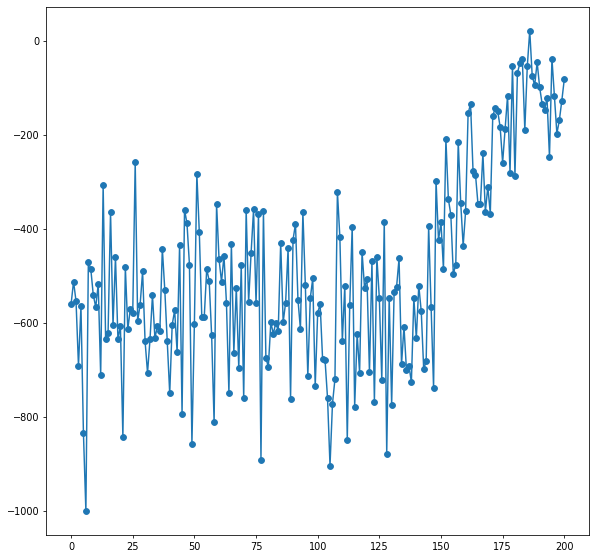

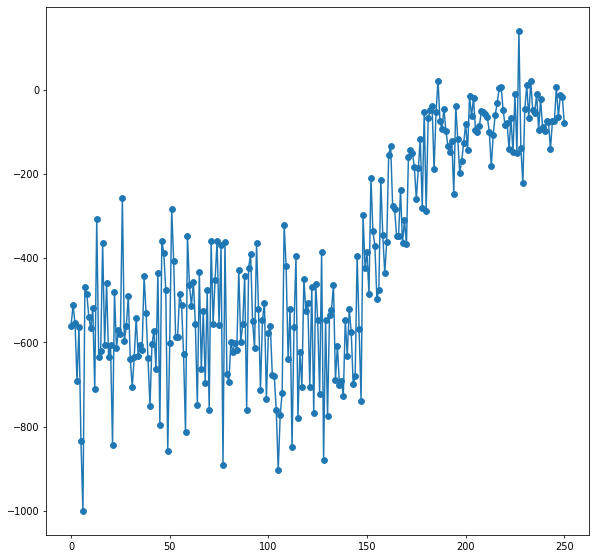

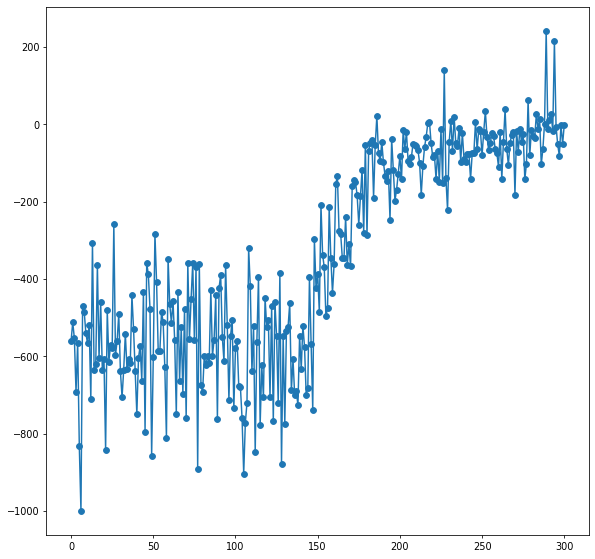

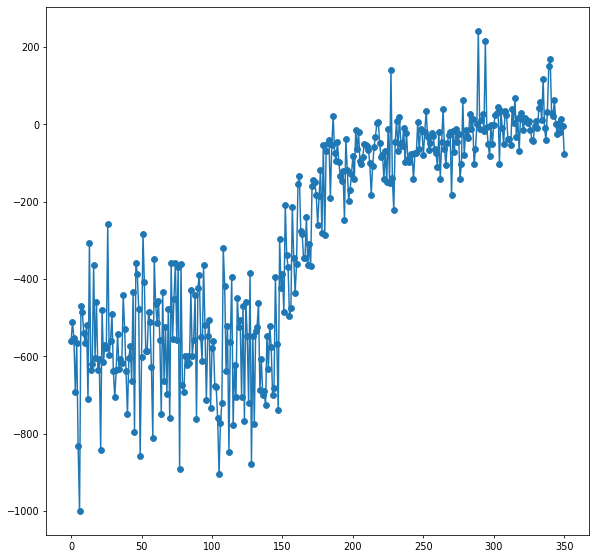

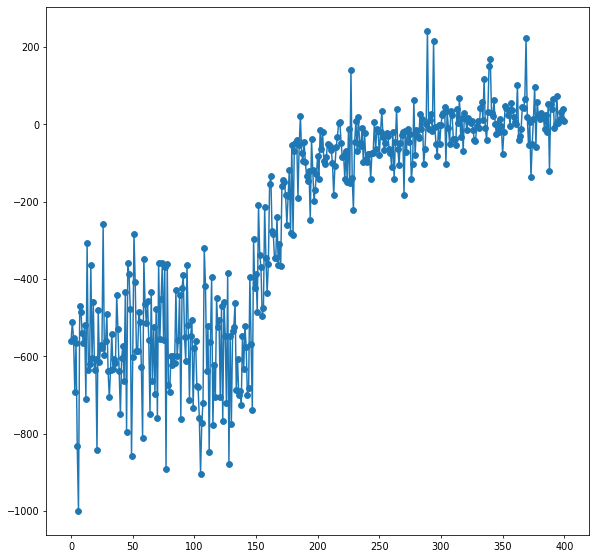

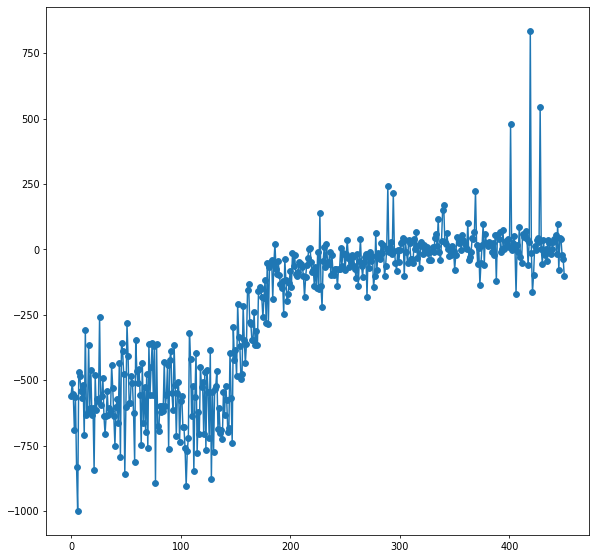

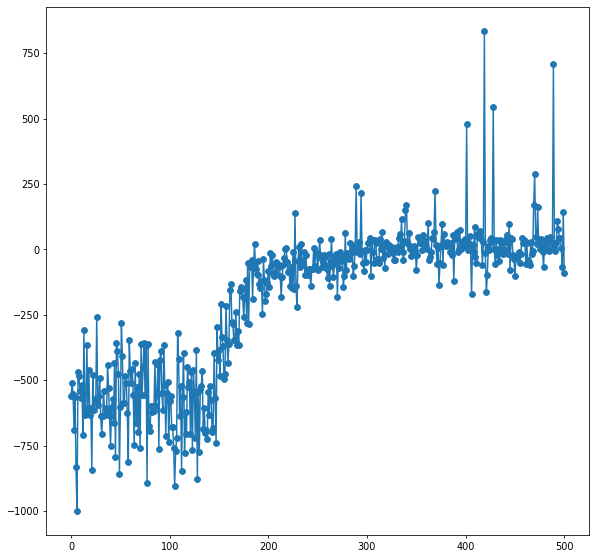

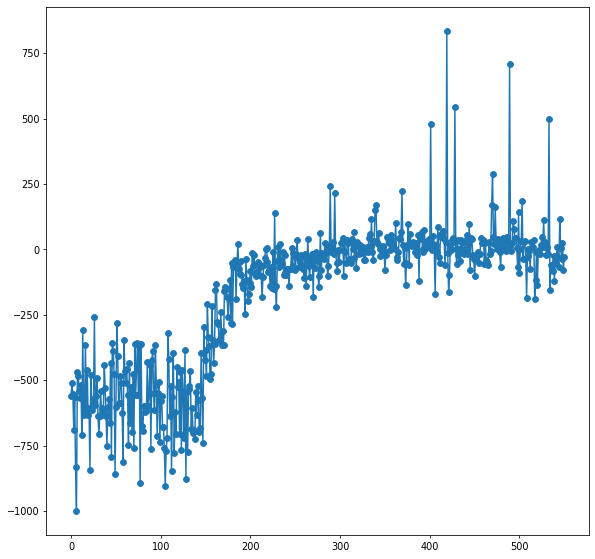

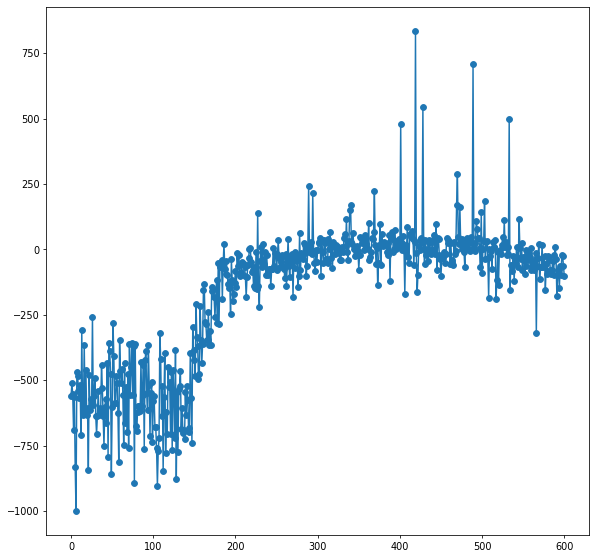

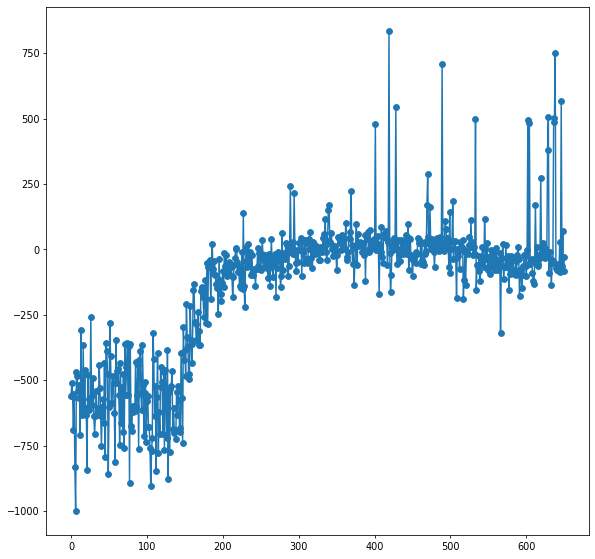

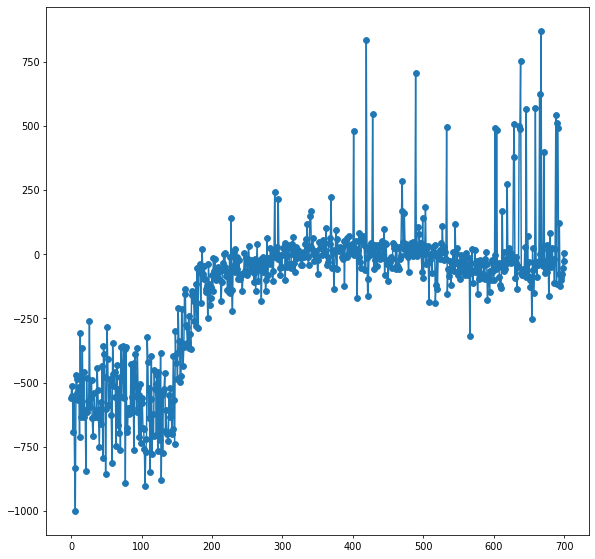

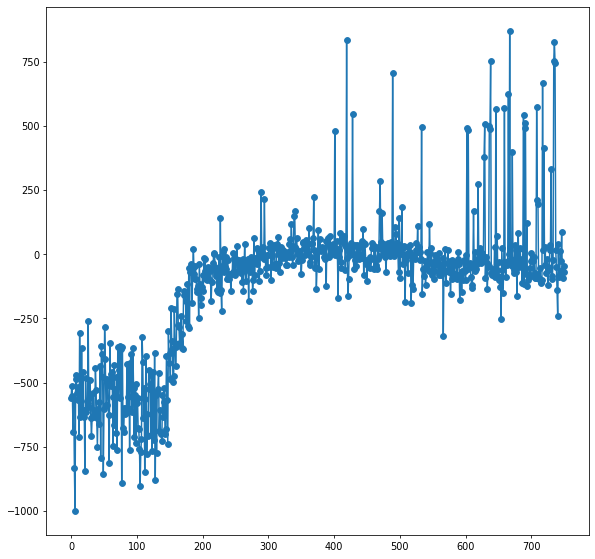

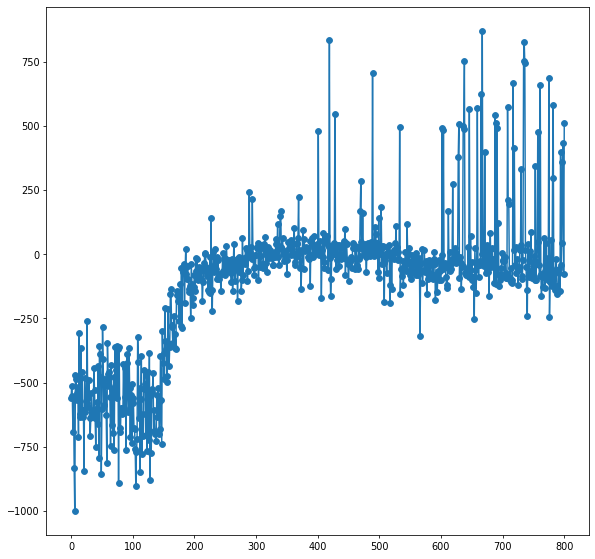

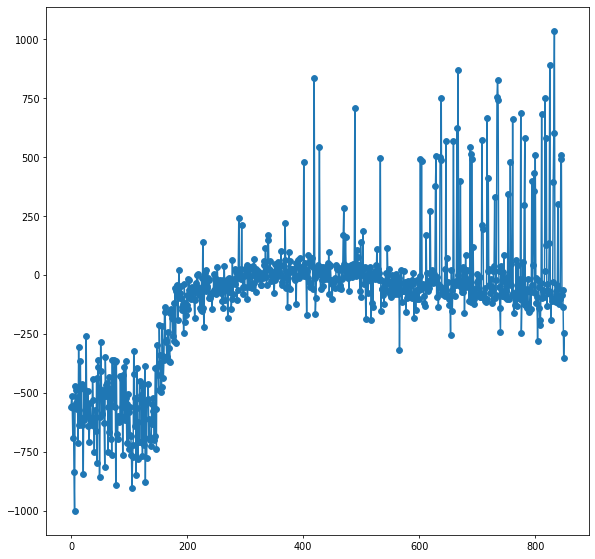

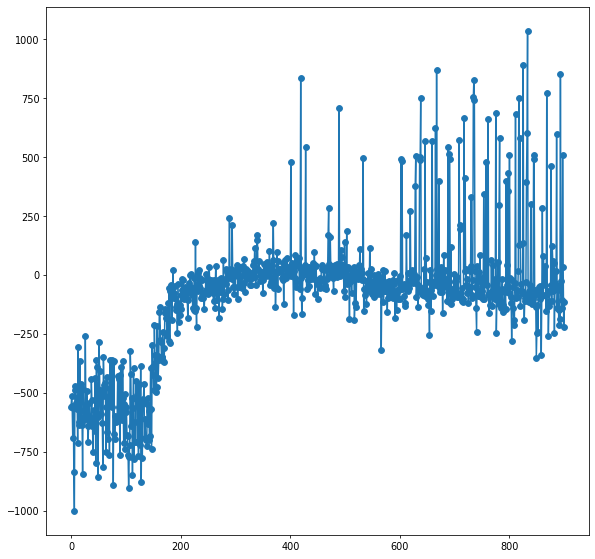

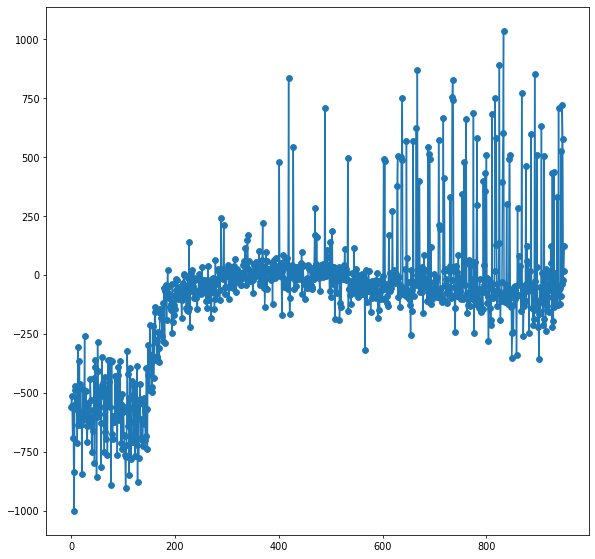

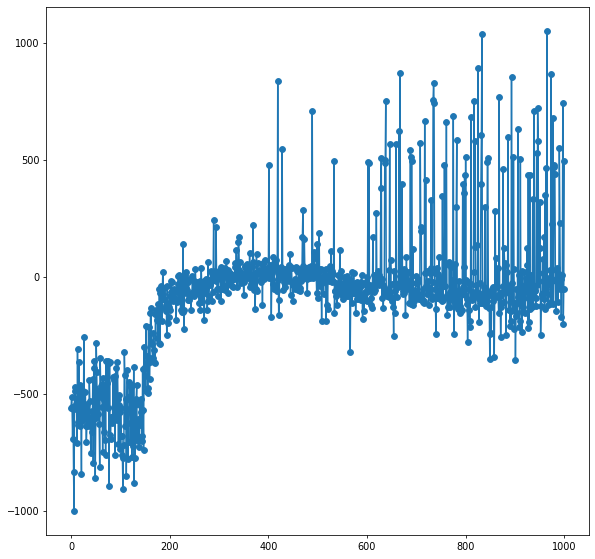

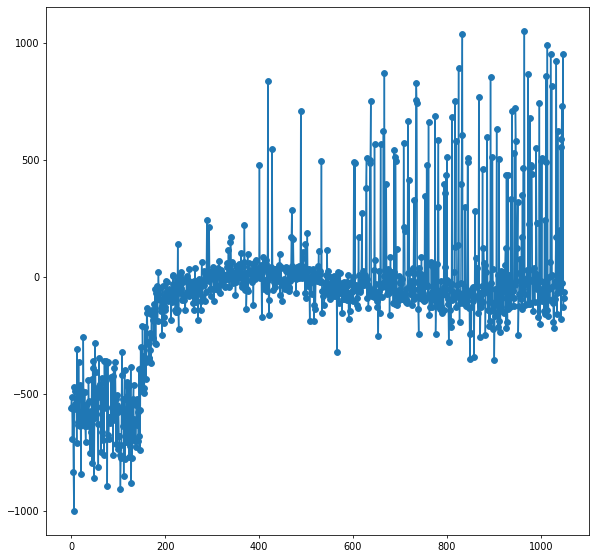

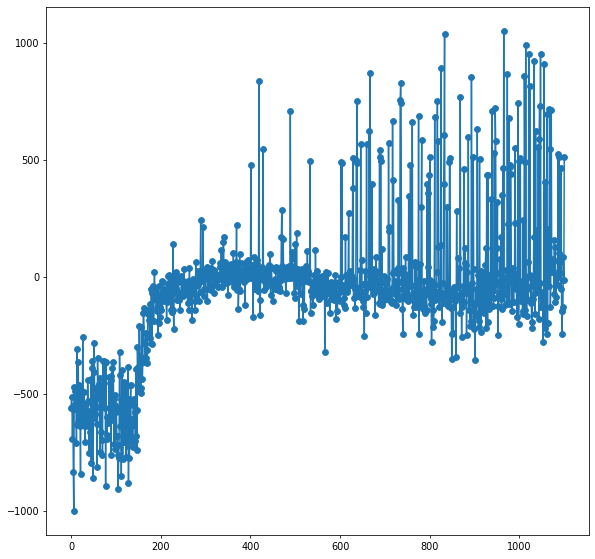

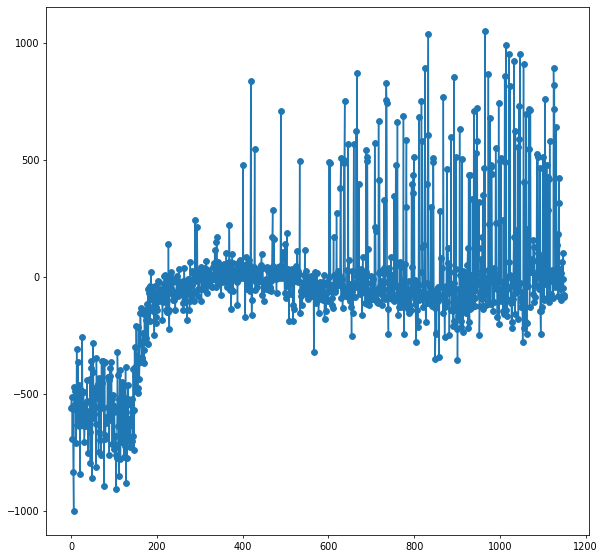

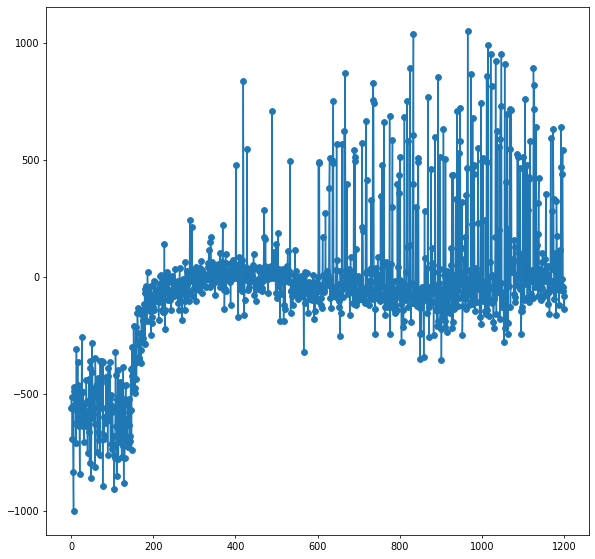

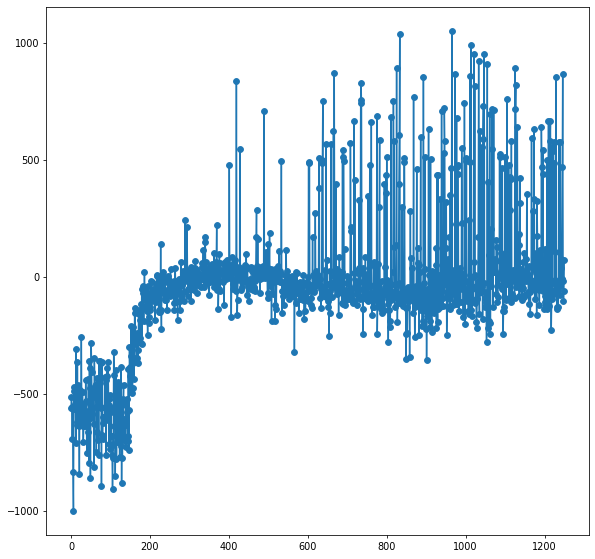

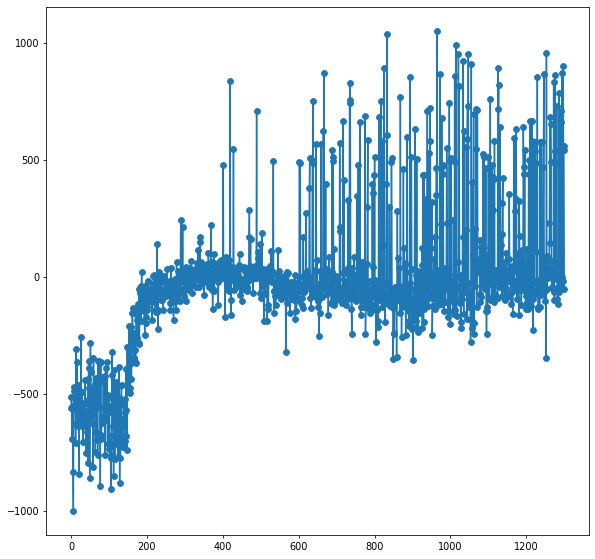

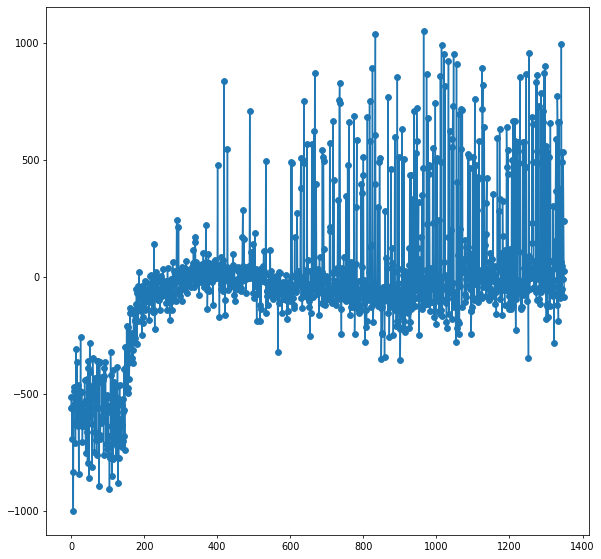

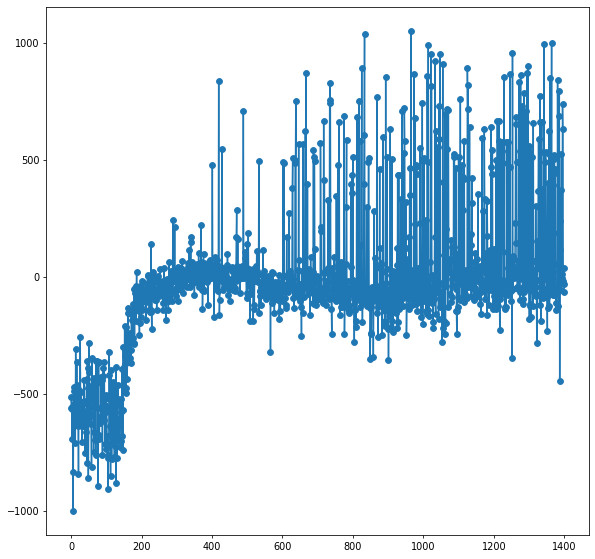

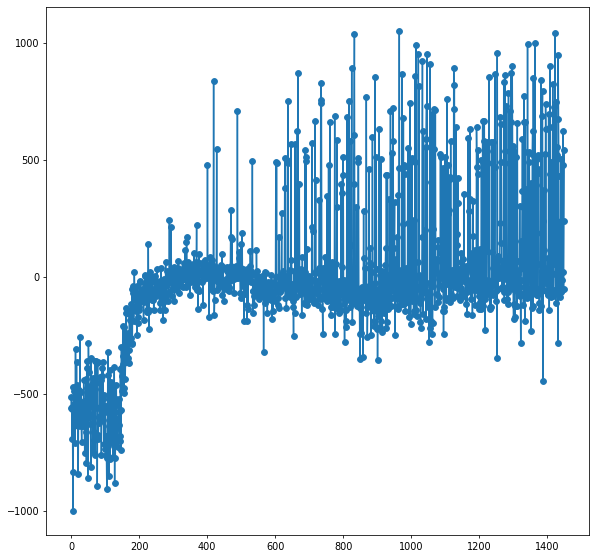

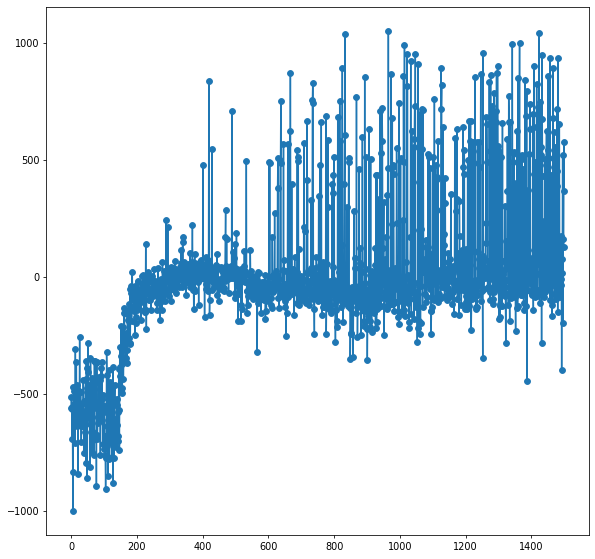

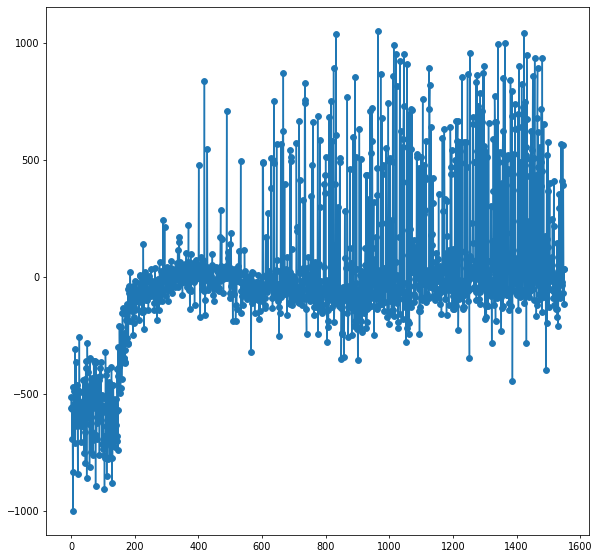

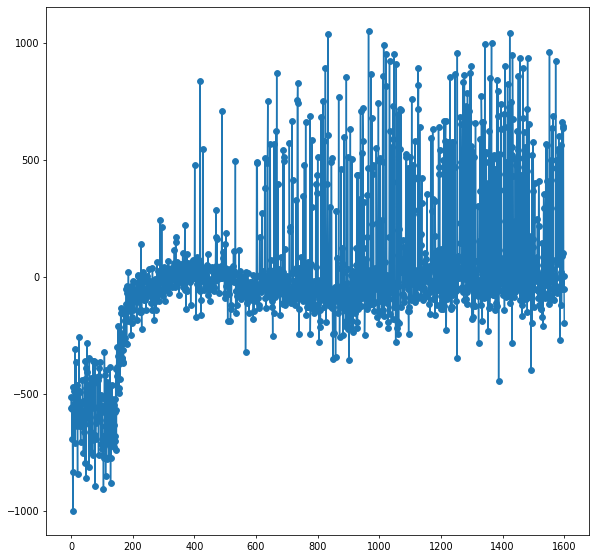

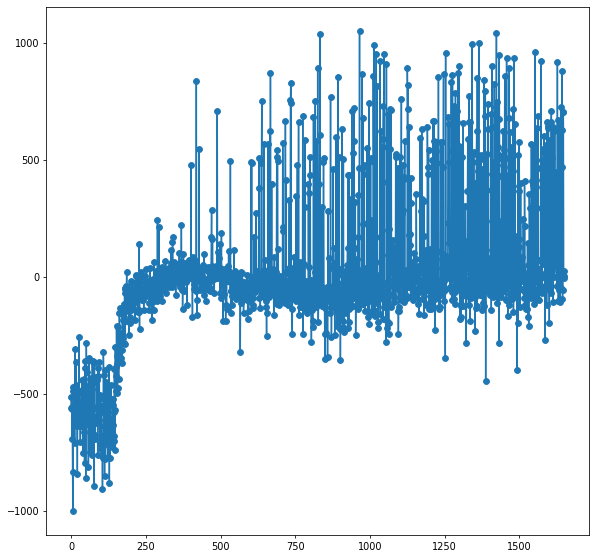

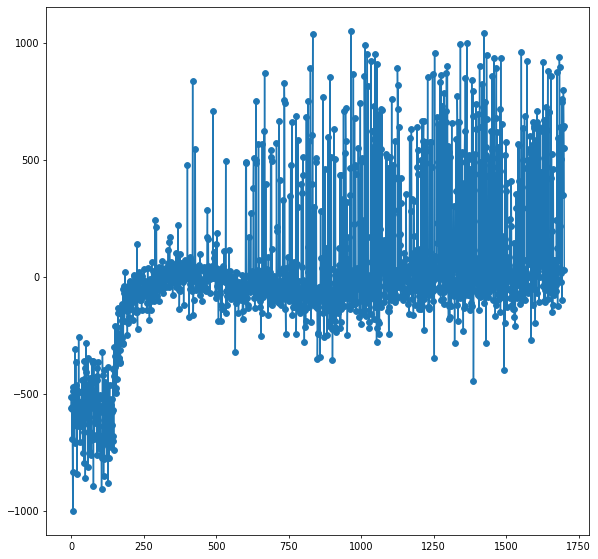

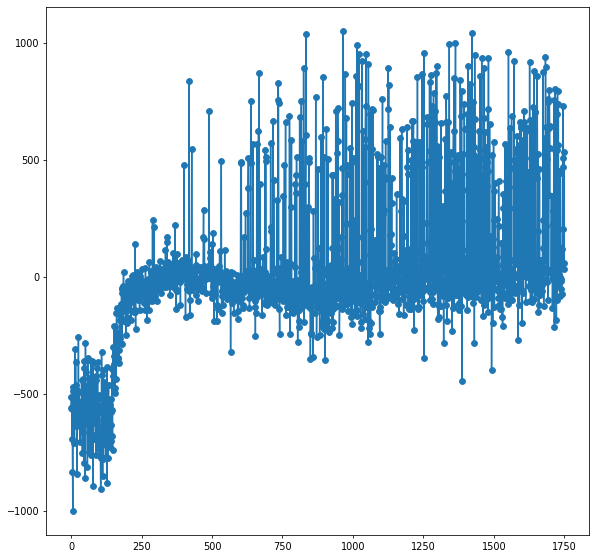

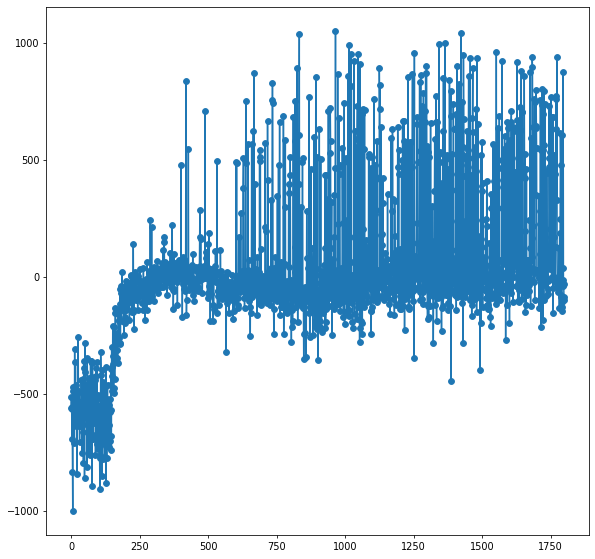

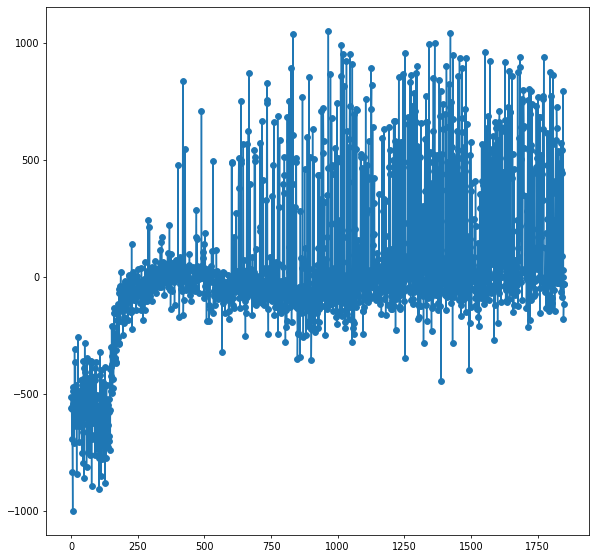

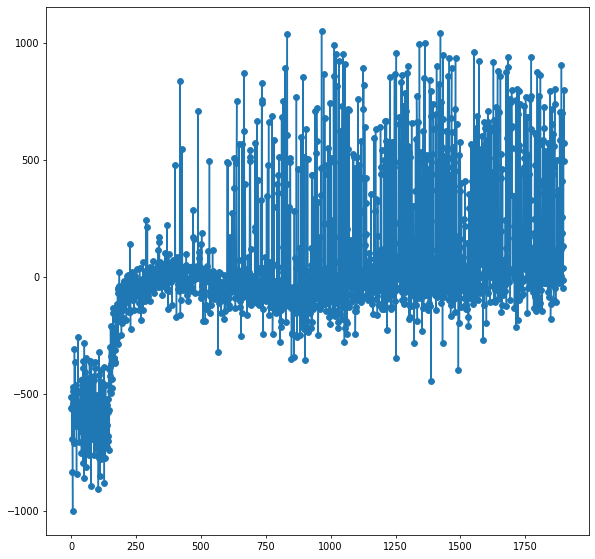

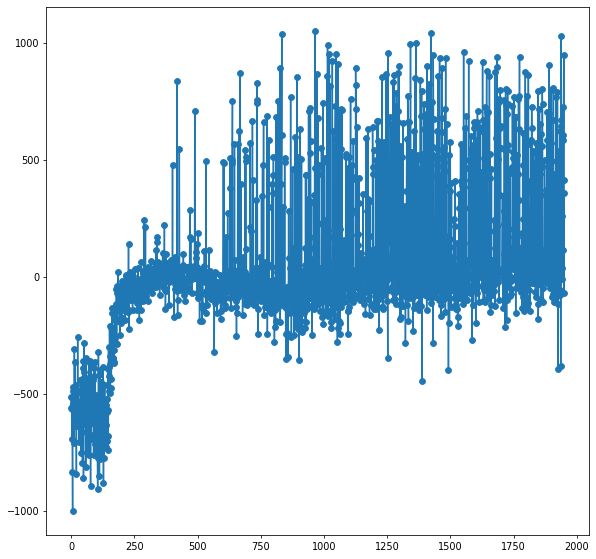

In [215]:
###############################  training  ####################################
env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(SEED)                                          # 设置Gym的随机数种子
torch.manual_seed(SEED)                                 # 设置pytorch的随机数种子

env.set_env_mode(obs_mode='state', reward_type='dense')

s_dim = env.observation_space.shape[0]                  # 状态空间
a_dim = env.action_space.shape[0]                       # 动作空间
a_bound = 1                                             # 动作取值区间,对称区间，故只取上界
hidden_dim = 512
ddpg = DDPG(a_dim, s_dim, a_bound, hidden_dim)
ou_noise = OUNoise(env.action_space)

var_t = 0

if LOAD_MODEL:
    ddpg.load_model()

    
if LOAD_MEM:
    ddpg.load_memory()

if LOAD_PRETRAIN:
    ddpg.load_pretrain()


if LOAD_MODEL or LOAD_MEM:
    var = 1.5
    var_t = 100000

if LOAD_PRETRAIN:
    var = 0.2

    
t1 = time.time()                                        # 开始时间



for i in range(MAX_EPISODES):
    s = env.reset(level = 1)
    ep_reward = 0

    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render('human')

        # Add exploration noise
        a = ddpg.choose_action(s)

        #a = np.clip(np.random.normal(a, var), -1, 1)    # add randomness to action selection for exploration
        a = ou_noise.get_action(a, var_t)
        
        a = a.numpy()
        
        s_, r, done, info = env.step(a)
        
        info_ = info.get('eval_info')
        
        if info_.get('success'):
            print('SUCCESS')
            ddpg.Record_success(i)
            r += 100 #+200
        
        r += 10
        r = r * 200
        r+= 200
        r += info.get('qpos')*4000
        #print(r)
        
#        if info.get('qpos') >= 0.05:
#            print('yeah: ', info.get('qpos'), r)
#            print(done)
        
        
        ddpg.store_transition(s, a, r, s_)         # 为什么要对reward归一化
    
        
        if ddpg.pointer > ddpg.memory_capacity or LOAD_MEM:         # 经验池已满
            if var > var_low_bound:
                #var *= .9998                            # 学习阶段逐渐降低动作随机性decay the action randomness
                var_t += 1
            ddpg.learn()                                # 开始学习

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS -1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward/j), 'Explore: %.2f' % min(1.0, var_t / 100000))
            
            ddpg.store_reward(ep_reward/j)
            
#            if  ep_reward/j > 400:
#                RENDER = True
            if (i % CHECK_POINT_EPI) == 0 and i != 0:
                ddpg.save('Check_Points/' + str(i) + 'epi')
       
            break
               
print('Running time: ', time.time() - t1)

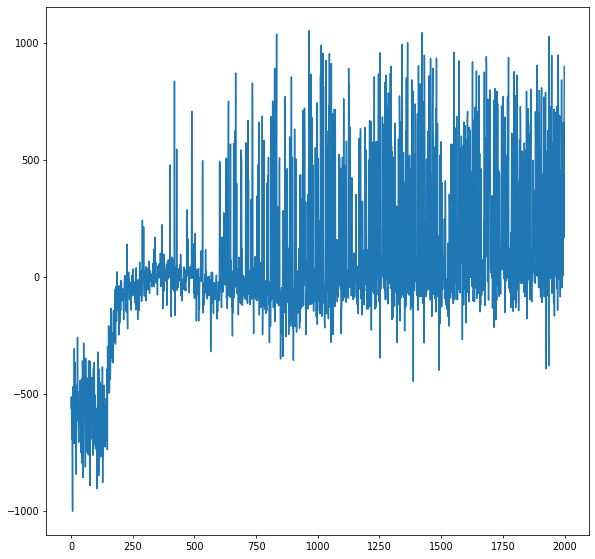

In [216]:
ddpg.plot_rewards(scatter= False)

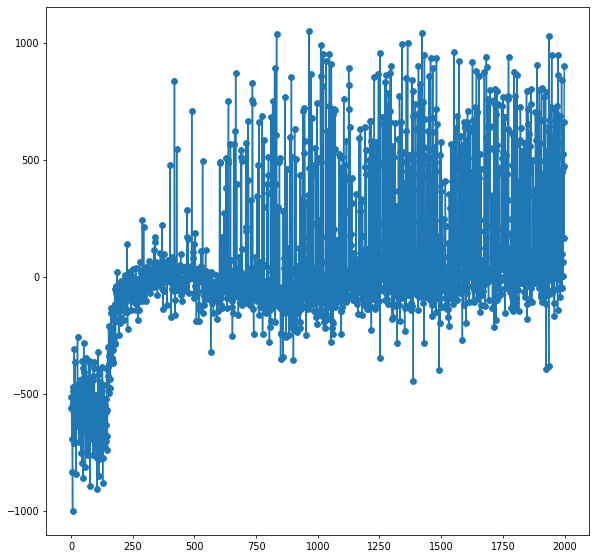

In [217]:
ddpg.save('carbinet_OU5')

In [177]:
max(ddpg.Reward_record)

998.7541999255623

In [74]:
data = pd.read_csv('./DPG model/carbinet_cat_2hidden256_3000epi/Rewards.csv')
y = np.array(data).squeeze()
max(y)

377.3678001151299

In [153]:
info

{'eval_info': {'cabinet_static': True, 'open_enough': False, 'success': False},
 'dist_ee_to_handle': array([0.20629548, 0.24817635]),
 'angle1': 1.0530481193160146,
 'angle2': 0.2783010426185387,
 'dist_ee_mid_to_handle': -0.22327554922694556,
 'rew_ee_handle': -0.45447183132933533,
 'rew_ee_mid_handle': -1.0,
 'qpos_rew': 0,
 'qvel_rew': 0,
 'gripper_angle_err': 15.945475176132721,
 'gripper_angle_rew': -0.265757919602212,
 'gripper_vel_norm': 0.0,
 'gripper_ang_vel_norm': 0.0,
 'qpos': 0.0,
 'qvel': 0.0,
 'target_qpos': 0.23135713040828706,
 'reward_raw': -3.7202297509315474,
 'stage_reward': -7.0,
 'TimeLimit.truncated': True}

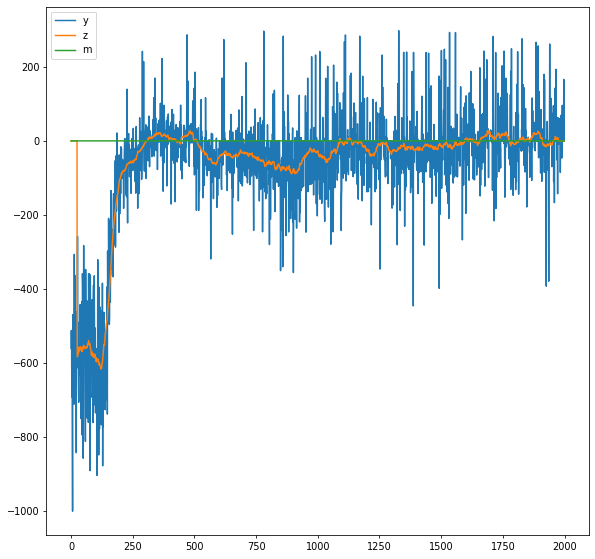

maximum success rate:  0.02
maximum mean rewards:  27.502343652835634


In [224]:
data = pd.read_csv('./DPG model/carbinet_OU5/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])

size = 50

z = np.zeros(len(y))
m = ddpg.Success_record
m_ = np.zeros(len(y))
for i in range(len(y)):
    if y[i] >= 300:
        y[i] = 0
    
for i in range(len(y)):

    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward
        
        if(m[i + j - int(size/2)] == 0):
            m_[i] += 1                  #success rate
        
    z[i] = z[i]/size
    m_[i] = m_[i]/size

plt.figure(figsize=(10, 10), dpi=70)

plt.plot(x, y)
plt.plot(x, z)
plt.plot(x, m_)

plt.legend(['y','z','m'])
plt.show()

print('maximum success rate: ', max(m)/size)
print('maximum mean rewards: ', max(z))

In [227]:
max(m_)

0.02

In [201]:
'a' + str(50)

'a50'

In [202]:
'Check_Points/' + str(50) + 'epi'

'Check_Points/50epi'

In [211]:
os.rmdir('./DPG model/' + 'Check_Points/' + str(50) + 'epi')